## Masked Autoencoders: Visualization Demo

This is a visualization demo using our pre-trained MAE models. No GPU is needed.

### Prepare
Check environment. Install packages if in Colab.


In [61]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install timm==0.4.5  # 0.3.2 does not work in Colab
    !git clone https://github.com/facebookresearch/mae.git
    sys.path.append('./mae')
else:
    sys.path.append('..')
import models_bmae

### Define utils

In [62]:
# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])


def show_image(image, title=""):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis("off")
    return


def prepare_model(chkpt_dir, arch="bmae_deit_tiny_patch4"):
    # build model
    model = getattr(models_bmae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location="cpu", weights_only=False)
    msg = model.load_state_dict(checkpoint["model"], strict=False)
    print(msg)
    return model


def run_one_image(img, model, ckpt_name=""):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum("nhwc->nchw", x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.75)
    y = model.unpatchify(y)
    y = torch.einsum("nchw->nhwc", y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0] ** 2 * 3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum("nchw->nhwc", mask).detach().cpu()

    x = torch.einsum("nchw->nhwc", x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams["figure.figsize"] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")
    if ckpt_name:
        plt.savefig("../results/" + ckpt_name + ".png", bbox_inches="tight")

    plt.show()

### Load an image

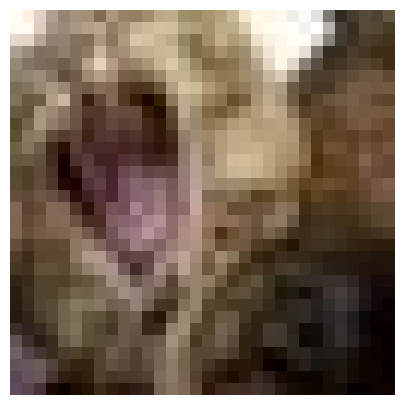

In [63]:
# load an image
# img_url = "https://github.com/YoongiKim/CIFAR-10-images/blob/master/test/airplane/0021.jpg?raw=true"  # airplane
img_url = "https://github.com/YoongiKim/CIFAR-10-images/blob/master/test/cat/0003.jpg?raw=true"  # cat
# img_url = 'https://user-images.githubusercontent.com/11435359/147743081-0428eecf-89e5-4e07-8da5-a30fd73cc0ba.jpg' # cucumber, from ILSVRC2012_val_00047851
img = Image.open(requests.get(img_url, stream=True).raw)
img = img.resize((32, 32))
img = np.array(img) / 255.0

assert img.shape == (32, 32, 3)

# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

plt.rcParams["figure.figsize"] = [5, 5]
show_image(torch.tensor(img))

### Load a pre-trained MAE model

In [ ]:
# This is an MAE model trained with pixels as targets for visualization (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
# !wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large.pth

chkpt_dir = "../checkpoints/pretrain-ema.pth"
# chkpt_dir = "../checkpoints/pretrain-ema-newpred.pth"
# chkpt_dir = "../checkpoints/pretrain-k2-layer12-newpred.pth"
# chkpt_dir = "../checkpoints/pretrain-k4-layer12-newpred.pth"
# chkpt_dir = "../checkpoints/pretrain-k5-layer12-newpred.pth"
# chkpt_dir = "../checkpoints/pretrain-k8-layer12-newpred.pth"
# chkpt_dir = "../checkpoints/pretrain-k10-layer12-newpred.pth"
# chkpt_dir = "../checkpoints/pretrain-k20-layer12-newpred.pth"

model_mae = prepare_model(chkpt_dir, "bmae_deit_tiny_patch4")
print("Model loaded.")
ckpt_name = chkpt_dir.split("/")[-1][:-4]

Use new feature predictor: False
_IncompatibleKeys(missing_keys=[], unexpected_keys=['feature_mask_token', 'feature_pos_embed', 'feature_embed.weight', 'feature_embed.bias', 'feature_blocks.0.norm1.weight', 'feature_blocks.0.norm1.bias', 'feature_blocks.0.attn.qkv.weight', 'feature_blocks.0.attn.qkv.bias', 'feature_blocks.0.attn.proj.weight', 'feature_blocks.0.attn.proj.bias', 'feature_blocks.0.norm2.weight', 'feature_blocks.0.norm2.bias', 'feature_blocks.0.mlp.fc1.weight', 'feature_blocks.0.mlp.fc1.bias', 'feature_blocks.0.mlp.fc2.weight', 'feature_blocks.0.mlp.fc2.bias', 'feature_blocks.1.norm1.weight', 'feature_blocks.1.norm1.bias', 'feature_blocks.1.attn.qkv.weight', 'feature_blocks.1.attn.qkv.bias', 'feature_blocks.1.attn.proj.weight', 'feature_blocks.1.attn.proj.bias', 'feature_blocks.1.norm2.weight', 'feature_blocks.1.norm2.bias', 'feature_blocks.1.mlp.fc1.weight', 'feature_blocks.1.mlp.fc1.bias', 'feature_blocks.1.mlp.fc2.weight', 'feature_blocks.1.mlp.fc2.bias', 'feature_block

### Run MAE on the image

MAE with pixel reconstruction:


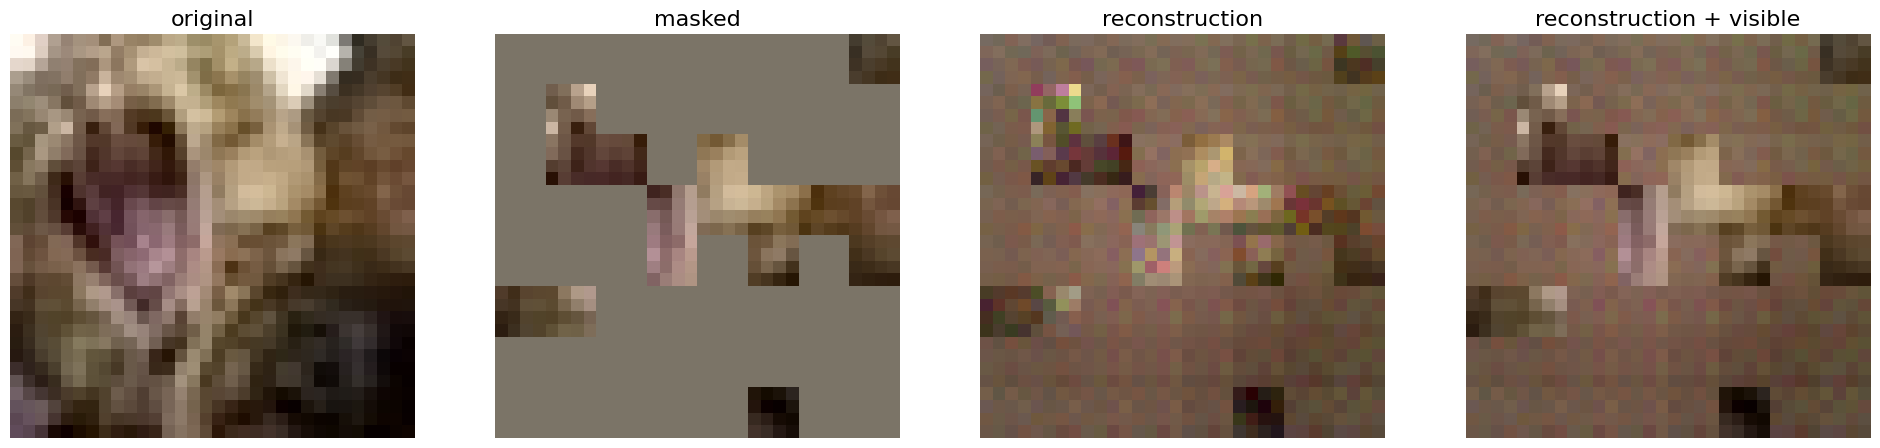

In [65]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print("MAE with pixel reconstruction:")
run_one_image(img, model_mae, ckpt_name)
# save the figure in '../results/'
# plt.savefig(f"../results/{ckpt_name}.png")